In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import glob
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt

def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    lossm = nn.MSELoss()
    lossp =torch.norm((torch.subtract(labels[:,0:2],out[:,0:2])))
    lossn =torch.norm(1-torch.norm((labels[:,3:6]*out[:,3:6]).sum (dim = 1)))
    lossp = lossm(labels[:,0:2],out[:,0:2])
    lossn = lossm(labels[:,3:6],out[:,3:6])
    floss = lossp + lossn
    #mloss = lossm(out,labels)
    return floss



class VODataset(Dataset):
    def __init__(self, data_dir):
        # data_dir = "/media/storage/lost+found/CV/P4/Phase2/Data/"
        self.Im_files = sorted(glob.glob("/home/adhi/Sin/Frames/*.png"))
        f = open("/home/adhi/Sin/pose_quat.csv", "r")
        reader = csv.reader(f)
        data = []
        for row in reader:
            data.append(row)
        self.data = np.array(data).astype(np.float32)
        
    def __len__(self):
        return len(self.Im_files)
    
    def __getitem__(self, idx):
        Current_Id = idx
        Previous_Id = idx - 1
        Im1 = cv2.imread(self.Im_files[Previous_Id])
        Im1 = Im1/255
        Im2 = cv2.imread(self.Im_files[Current_Id])
        Im2 = Im2/255
        # FundamentalMatrix = self.Get_Fundamental_Matrix(Im1, Im2)
        Im = np.dstack((Im1, Im2))
        torchIm = torch.from_numpy(Im).permute(2,0,1).float()

        Current_IMU = self.data[Current_Id]
        Previous_IMU = self.data[Previous_Id]
        # Position_Diff = Current_IMU[0:3] - Previous_IMU[0:3]
        # Orientation_Diff = Current_IMU[3:7] - Previous_IMU[3:7]
        Diff = Current_IMU
        return torchIm, Diff

    def Get_Fundamental_Matrix(self, Im1, Im2):
        sift = cv2.SIFT_create()
        kp1, des1 = sift.detectAndCompute(Im1, None)
        kp2, des2 = sift.detectAndCompute(Im2, None)
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,f,des2, k=2)
        pts1 = []
        pts2 = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                pts1.append(kp1[m.queryIdx].pt)
                pts2.append(kp2[m.trainIdx].pt)
        pts1 = np.int32(pts1)
        pts2 = np.int32(pts2)
        F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
        pts1 = pts1[mask.ravel()==1]
        pts2 = pts2[mask.ravel()==1]

        F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

        return F

class ResBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        
        super(ResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=False)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = torch.add(out, identity)
        # out = self.relu(out)
        return out

class VO_CNN(nn.Module):
    
    def __init__(self):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################

      super().__init__()
      #self.lstm1 = nn.LSTM(6,6,2)
      self.layer1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=(7, 7), stride=2, padding=3),
            nn.ReLU()
        )
      self.layer2 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=2, padding=2),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
      self.layer3 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(5, 5), stride=2, padding=2),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
      self.layer4 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
      self.layer5= nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(256,512, kernel_size=(3, 3), stride=2, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
      self.layer6 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
            # nn.BatchNorm2d(16),
            # nn.AvgPool2d(2,2)
        )
      self.layer7 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=2, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
      self.layer8 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*8*10, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,3)
        )
      self.layer9 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*8*10, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,4)
        )
      
      


    def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################

      out = self.layer1(xb)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = self.layer5(out)
      out = self.layer6(out)
      out = self.layer6(out)
      out = self.layer6(out)
      cnn_out = self.layer7(out)
      #cnn_out = cnn_out.view(16,81920)
      #cnn_out=cnn_out.unsqueeze(1)
      #o_R,_ = self.LSTM_R(cnn_out)
      #o_T,_= self.LSTM_T(cnn_out)
      #cnn_out = cnn_out.view(cnn_out.size(0), -1)
      pose= self.layer8(cnn_out)
      ori = self.layer9(cnn_out)
      output = torch.cat((pose, ori), dim=1)
      #output = self.layer9(cnn_out)
      return output


class VO_LSTM(nn.Module):
    def __init__(self):
        super(VO_LSTM, self).__init__()
        # Convolutional layers
        self.lstm = nn.LSTM(240*320, hidden_size=320, num_layers=1, batch_first=True)
        self.layer2 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(6, 16, kernel_size=(3, 3), stride=1, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
        self.layer3 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
        #self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        # LSTM layer
        # Fully connected layers
        self.fc1 = nn.Linear(640+240*320*32, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128,7)# Adjust num_poses according to your needs

    def forward(self, x):
        l1 = x.view(x.shape[0], x.shape[1], -1)
        l1, _ = self.lstm(l1)
        l1 = l1.reshape(l1.size(0), 2* 320 *1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.cat((x,l1),dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
torch.autograd.set_detect_anomaly(True)
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VO_CNN().to(Device)
Dataset = VODataset("/home/adhi/Downloads/")
dataloader = DataLoader(Dataset, batch_size=16, shuffle=True)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
Output=[]
Label = []
for epoch in range(100):
    for i, (data, label) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data.to(Device))
        Output.append(output.detach().cpu().numpy())
        Label.append(label.detach().cpu().numpy())
        loss = loss_fn(output, label.to(Device))
        loss.backward()
        optimizer.step()
        print("Epoch: %d, Batch: %d, Loss: %.4f" % (epoch, i, loss.item()))
torch.save(model.state_dict(), "/home/adhi/Downloads/Checkpoints/VO_CNN"+str(loss.item())+".pth")       

def Test():
    torch.autograd.set_detect_anomaly(True)
    Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VO_CNN().to(Device)
        # Load checkpoint
    model.load_state_dict(torch.load("/home/adhi/Checkpoints/VO_CNN0.0029919457156211138.pth"))
    Dataset = VODataset("/home/adhi/")
    dataloader = DataLoader(Dataset, batch_size=16, shuffle=False)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
        # Loss = nn.MSELoss()

    model.eval()
    VO_X = []
    VO_Y = []
    GT_X = []
    GT_Y = []


    for i, (data, label) in enumerate(dataloader):
        if i == 0:
            continue
        # optimizer.zero_grad()
        output = model(data.to(Device))
        loss = loss_fn(output, label.to(Device))
        # loss.backward()
        # optimizer.step()
        for j in range(16):
            print("Output: ", output[j].detach().cpu().numpy()-1)
            print("Label: ", label[j].detach().cpu().numpy()-1)
            print("Loss: ", loss.item())
            print("\n")
            VO_X.append(output[j][0].detach().cpu().numpy()-1)
            VO_Y.append(output[j][1].detach().cpu().numpy()-1)
            GT_X.append(label[j][0].detach().cpu().numpy()-1)
            GT_Y.append(label[j][1].detach().cpu().numpy()-1)
    #             writer = csv.writer(f)
    #             writer.writerow([output[j].detach().cpu().numpy()-1, label[j].detach().cpu().numpy()-1,])

    f = open("VO_2.csv", "w")
    writer = csv.writer(f)
    writer.writerow(["VO_X", "VO_Y", "GT_X", "GT_Y"])
    for i in range(len(VO_X)):
        writer.writerow([VO_X[i], VO_Y[i], GT_X[i], GT_Y[i]])
    f.close()

    plt.figure()
    plt.plot(VO_Y,VO_X,'ro')
    plt.plot(GT_Y,GT_X,'bo')
    plt.show()

Epoch: 0, Batch: 0, Loss: 0.3410
Epoch: 0, Batch: 1, Loss: 0.3290
Epoch: 0, Batch: 2, Loss: 0.3012
Epoch: 0, Batch: 3, Loss: 0.2222
Epoch: 0, Batch: 4, Loss: 0.1619
Epoch: 0, Batch: 5, Loss: 0.2112
Epoch: 0, Batch: 6, Loss: 0.0705
Epoch: 0, Batch: 7, Loss: 0.0914
Epoch: 0, Batch: 8, Loss: 0.1094
Epoch: 0, Batch: 9, Loss: 0.0744
Epoch: 0, Batch: 10, Loss: 0.0522
Epoch: 0, Batch: 11, Loss: 0.0443
Epoch: 0, Batch: 12, Loss: 0.0387
Epoch: 0, Batch: 13, Loss: 0.0420
Epoch: 0, Batch: 14, Loss: 0.0402
Epoch: 0, Batch: 15, Loss: 0.0435
Epoch: 0, Batch: 16, Loss: 0.0336
Epoch: 0, Batch: 17, Loss: 0.0343
Epoch: 0, Batch: 18, Loss: 0.0313
Epoch: 0, Batch: 19, Loss: 0.0401
Epoch: 0, Batch: 20, Loss: 0.0429
Epoch: 0, Batch: 21, Loss: 0.0298


KeyboardInterrupt: 

In [136]:
class VODataset(Dataset):
    def __init__(self):
        # data_dir = "/media/storage/lost+found/CV/P4/Phase2/Data/"
        self.Im_files = sorted(glob.glob("/home/adhi/Mix_Traj_1/Frames_Mix_1/Frames/*.png"))
        f = open("/home/adhi/Mix_Traj_1/pose_and_quat.csv", "r")
        reader = csv.reader(f)
        data = []
        for row in reader:
            data.append(row)
        self.data = np.array(data).astype(np.float32)
        
    def __len__(self):
        return len(self.Im_files)
    
    def __getitem__(self, idx):
        Current_Id = idx
        Previous_Id = idx - 1
        Im1 = cv2.imread(self.Im_files[Previous_Id])
        Im1 = Im1/255
        Im2 = cv2.imread(self.Im_files[Current_Id])
        Im2 = Im2/255
        # FundamentalMatrix = self.Get_Fundamental_Matrix(Im1, Im2)
        Im = np.dstack((Im1, Im2))
        torchIm = torch.from_numpy(Im).permute(2,0,1).float()

        Current_IMU = self.data[Current_Id]
        Previous_IMU = self.data[Previous_Id]
        # Position_Diff = Current_IMU[0:3] - Previous_IMU[0:3]
        # Orientation_Diff = Current_IMU[3:7] - Previous_IMU[3:7]
        Diff = Current_IMU
        return torchIm, Diff

    def Get_Fundamental_Matrix(self, Im1, Im2):
        sift = cv2.SIFT_create()
        kp1, des1 = sift.detectAndCompute(Im1, None)
        kp2, des2 = sift.detectAndCompute(Im2, None)
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,f,des2, k=2)
        pts1 = []
        pts2 = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                pts1.append(kp1[m.queryIdx].pt)
                pts2.append(kp2[m.trainIdx].pt)
        pts1 = np.int32(pts1)
        pts2 = np.int32(pts2)
        F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
        pts1 = pts1[mask.ravel()==1]
        pts2 = pts2[mask.ravel()==1]

        F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

        return F

TypeError: __init__() takes 2 positional arguments but 4 were given

1
torch.Size([16, 6, 240, 320])
Output:  [-1.1961082  -1.0838801  -4.136405   -0.04940063 -1.0073347  -1.0153639
 -1.20297   ]
Label:  [-1.         -1.         -2.9996502   0.         -0.9999815  -1.000103
 -0.99999213]
Loss:  0.009259931743144989


1
torch.Size([16, 6, 240, 320])
Output:  [-1.1826489  -1.0625011  -4.177801   -0.04508466 -1.0065995  -1.0148648
 -1.2060705 ]
Label:  [-1.        -1.        -2.9996037  0.        -0.9999799 -1.0001167
 -0.9999915]
Loss:  0.009259931743144989


1
torch.Size([16, 6, 240, 320])
Output:  [-1.1655552  -1.0921415  -4.1320934  -0.04324085 -1.007517   -1.0178635
 -1.2036787 ]
Label:  [-0.99999994 -1.         -2.9995542   0.         -0.9999784  -1.0001312
 -0.9999909 ]
Loss:  0.009259931743144989


1
torch.Size([16, 6, 240, 320])
Output:  [-1.1748586  -1.0994606  -4.1436353  -0.04590231 -1.0087796  -1.0149267
 -1.2073777 ]
Label:  [-0.99999994 -1.         -2.9995017   0.         -0.999977   -1.0001467
 -0.9999903 ]
Loss:  0.009259931743144989


1
t

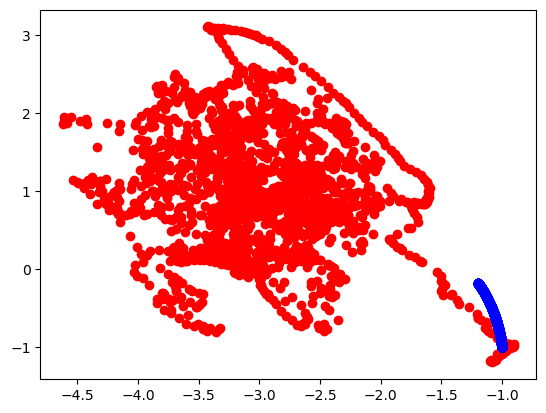

In [141]:
torch.autograd.set_detect_anomaly(True)
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VO_CNN().to(Device)
    # Load checkpoint
model.load_state_dict(torch.load("/home/adhi/Downloads/VO_CNN0.03273884952068329.pth"))
Dataset = VODataset("/home/adhi/Sin/Frames")
dataloader = DataLoader(Dataset, batch_size=16, shuffle=False)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    # Loss = nn.MSELoss()

model.eval()
VO_X = []
VO_Y = []
GT_X = []
GT_Y = []


for i, (data, label) in enumerate(dataloader):
    if i == 0:
        continue
    # optimizer.zero_grad()
    output = model(data.to(Device))
    loss = loss_fn(output, label.to(Device))
    # loss.backward()
    # optimizer.step()
    for j in range(16):
        print(i)
        print(data.shape)
        if i==118:
            break
        print("Output: ", output[j].detach().cpu().numpy()-1)
        print("Label: ", label[j].detach().cpu().numpy()-1)
        print("Loss: ", loss.item())
        print("\n")
        VO_X.append(output[j][0].detach().cpu().numpy()-1)
        VO_Y.append(output[j][1].detach().cpu().numpy()-1)
        GT_X.append(label[j][0].detach().cpu().numpy()-1)
        GT_Y.append(label[j][1].detach().cpu().numpy()-1)
#             writer = csv.writer(f)
#             writer.writerow([output[j].detach().cpu().numpy()-1, label[j].detach().cpu().numpy()-1,])

f = open("/home/adhi/Sin/Frames/VO_2.csv", "w")
writer = csv.writer(f)
writer.writerow(["VO_X", "VO_Y", "GT_X", "GT_Y"])
for i in range(len(VO_X)):
    writer.writerow([VO_X[i], VO_Y[i], GT_X[i], GT_Y[i]])
f.close()

plt.figure()
plt.plot(VO_Y,VO_X,'ro')
plt.plot(GT_Y,GT_X,'bo')
plt.show()

In [167]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import csv

class IMUDataset(Dataset):
    def __init__(self, data_dir):
        IMU = open(data_dir+"Sin_GT_N.csv", "r")
        reader = csv.reader(IMU)
        IMU_Data = []
        for row in reader:
            IMU_Data.append(row)
        self.IMU_Data = np.array(IMU_Data).astype(np.float32)

        GT = open(data_dir+"pose_quat.csv", "r")
        reader = csv.reader(GT)
        data = []
        for row in reader:
            data.append(row)
            print(row)
        self.GT = np.array(data).astype(np.float32)
        
    def __len__(self):
        return len(self.IMU_Data)
    
    def __getitem__(self, idx):

        return self.IMU_Data[idx], self.GT[idx]

class DroneLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2 , output_size=7):
        super(DroneLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128,3)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x.unsqueeze_(1)
        

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        

        out, _ = self.lstm(x, (h0, c0))
        out = nn.functional.relu(self.fc1(out[:, -1, :]))
        pose = self.fc2(out)
        ori = self.fc3(out)
        output = torch.cat((pose, ori), dim=1)
        # Take output from the last time step only
        
        return output


# Create dataset and dataloader
dataset = IMUDataset("/home/adhi/Sin/")
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Initialize the model
input_size = 6 # 6 features from the IMU
hidden_size = 512  # Hidden size of LSTM cells
model = DroneLSTM(input_size, hidden_size)
model.load_state_dict(torch.load("/home/adhi/Checkpoints/checkpoint_epoch_Mix1HelMix3Mix4.pth"))
# Loss function
Loss = nn.MSELoss()

# Optimizer (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Directory to save checkpoints
checkpoint_dir = "/home/adhi/Checkpoints/Imu"
os.makedirs(checkpoint_dir, exist_ok=True)

# Training parameters
num_epochs = 25
save_every = 2  # Save checkpoint every 2 epochs
tloss=[]
# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    
    for batch_idx,(data,label) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data)
        
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print training progress
    avg_loss = running_loss / len(dataloader)
    tloss.append(avg_loss)
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Save checkpoint
    if epoch % save_every == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

print("Training finished.")

['0', '0', '0', '0', '0', '0', '0']
['0', '0', '-2', '1', '0', '0', '0']
['0', '0', '-1.999997085', '1', '1.84E-07', '-8.58E-07', '7.90E-08']
['0', '0', '-1.999991255', '1', '5.51E-07', '-2.57E-06', '2.37E-07']
['1.18E-11', '2.53E-12', '-1.999982511', '1', '1.10E-06', '-5.15E-06', '4.74E-07']
['5.92E-11', '1.27E-11', '-1.999970851', '1', '1.84E-06', '-8.58E-06', '7.90E-07']
['1.78E-10', '3.80E-11', '-1.999956277', '1', '2.75E-06', '-1.29E-05', '1.19E-06']
['4.14E-10', '8.86E-11', '-1.999938787', '1', '3.86E-06', '-1.80E-05', '1.66E-06']
['8.28E-10', '1.77E-10', '-1.999918383', '1', '5.14E-06', '-2.40E-05', '2.21E-06']
['1.49E-09', '3.19E-10', '-1.999895064', '1', '6.61E-06', '-3.09E-05', '2.85E-06']
['2.49E-09', '5.32E-10', '-1.99986883', '0.999999999', '8.26E-06', '-3.86E-05', '3.56E-06']
['3.91E-09', '8.36E-10', '-1.999839681', '0.999999999', '1.01E-05', '-4.72E-05', '4.35E-06']
['5.86E-09', '1.25E-09', '-1.999807617', '0.999999999', '1.19E-05', '-5.66E-05', '5.11E-06']
['8.46E-09', 

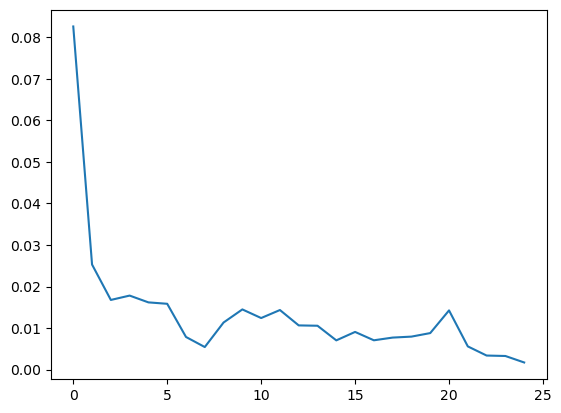

In [170]:
plt.figure()
plt.plot(tloss)

['0', '0', '0', '0', '0', '0', '0']
['0', '0', '-2', '1', '0', '0', '0']
['0', '0', '-1.999998268', '1', '-7.32E-07', '-7.32E-07', '-5.51E-08']
['0', '0', '-1.999994804', '1', '-2.20E-06', '-2.20E-06', '-1.65E-07']
['1.18E-11', '-1.18E-11', '-1.999989607', '1', '-4.39E-06', '-4.39E-06', '-3.31E-07']
['5.91E-11', '-5.91E-11', '-1.999982678', '1', '-7.32E-06', '-7.32E-06', '-5.51E-07']
['1.77E-10', '-1.77E-10', '-1.999974018', '1', '-1.10E-05', '-1.10E-05', '-8.27E-07']
['4.14E-10', '-4.14E-10', '-1.999963625', '1', '-1.54E-05', '-1.54E-05', '-1.16E-06']
['8.28E-10', '-8.28E-10', '-1.9999515', '1', '-2.05E-05', '-2.05E-05', '-1.54E-06']
['1.49E-09', '-1.49E-09', '-1.999937642', '0.999999999', '-2.64E-05', '-2.64E-05', '-1.98E-06']
['2.48E-09', '-2.48E-09', '-1.999922053', '0.999999999', '-3.30E-05', '-3.30E-05', '-2.48E-06']
['3.90E-09', '-3.90E-09', '-1.999904731', '0.999999999', '-4.03E-05', '-4.03E-05', '-3.03E-06']
['5.86E-09', '-5.86E-09', '-1.999885748', '0.999999998', '-4.83E-05',

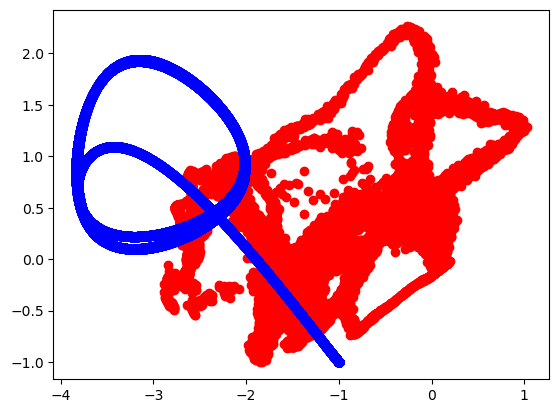

In [124]:
torch.autograd.set_detect_anomaly(True)
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 6  # 6 features from the IMU
hidden_size = 512  # Hidden size of LSTM cells
model = DroneLSTM(input_size, hidden_size).to(Device)
    # Load checkpoint
model.load_state_dict(torch.load("/home/adhi/Checkpoints/Imu/checkpoint_epoch_100.pth"))
Dataset = IMUDataset("/home/adhi/Mix_Traj_1/")
dataloader = DataLoader(Dataset, batch_size=16, shuffle=False)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    # Loss = nn.MSELoss()

model.eval()
VO_X = []
VO_Y = []
GT_X = []
GT_Y = []

for i, (data, label) in enumerate(dataloader):
    if i == 0:
        continue
    # optimizer.zero_grad()
    print(data)
    output = model(data.to(Device))
    loss = loss_fn(output, label.to(Device))
    # loss.backward()
    # optimizer.step()
    for j in range(16):
        print(i)
        if i==1250:
            break
        #print(output.detach().cpu().numpy())
        #print("Output: ", output[j].detach().cpu().numpy()-1)
        #print("Label: ", label[j].detach().cpu().numpy()-1)
        #print("Loss: ", loss.item())
        #print("\n")
        VO_X.append(output[j][0].detach().cpu().numpy()-1)
        VO_Y.append(output[j][1].detach().cpu().numpy()-1)
        GT_X.append(label[j][0].detach().cpu().numpy()-1)
        GT_Y.append(label[j][1].detach().cpu().numpy()-1)
#             writer = csv.writer(f)
#             writer.writerow([output[j].detach().cpu().numpy()-1, label[j].detach().cpu().numpy()-1,])

f = open("/home/adhi/Checkpoints/VO_2.csv", "w")
writer = csv.writer(f)
writer.writerow(["VO_X", "VO_Y", "GT_X", "GT_Y"])
for i in range(len(VO_X)):
    writer.writerow([VO_X[i], VO_Y[i], GT_X[i], GT_Y[i]])
f.close()

plt.figure()
plt.plot(VO_Y,VO_X,'ro')
plt.plot(GT_Y,GT_X,'bo')
plt.show()

In [75]:
def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    lossm = nn.MSELoss()
    lossp =torch.norm((torch.subtract(labels[:,0:2],out[:,0:2])))
    lossn =torch.norm(1-torch.norm((labels[:,3:6]*out[:,3:6]).sum (dim = 1)))
    #lossp = lossm(labels[:,0:2],out[:,0:2])
    #lossn = lossm(labels[:,3:6],out[:,3:6])
    floss = lossp + 150*lossn
    #mloss = lossm(out,labels)
    return floss


In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import glob
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt

def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    lossm = nn.MSELoss()
    #lossp =torch.norm((torch.subtract(labels[:,0:2],out[:,0:2])))
    #lossn =torch.norm(1-torch.norm((labels[:,3:6]*out[:,3:6]).sum (dim = 1)))
    lossp = lossm(labels[:,0:2],out[:,0:2])
    lossn = lossm(labels[:,3:6],out[:,3:6])
    floss = lossp + lossn
    #mloss = lossm(out,labels)
    return floss



class VIODataset(Dataset):
    def __init__(self, data_dir):
        # data_dir = "/media/storage/lost+found/CV/P4/Phase2/Data/"
        self.Im_files = sorted(glob.glob("/home/adhi/Mix_Traj_1/Frames_Mix_1/Frames/*.png"))
        f = open("/home/adhi/Mix_Traj_1/pose_and_quat.csv", "r")
        reader = csv.reader(f)
        data = []
        for row in reader:
            data.append(row)
        self.data = np.array(data).astype(np.float32)
        IMU = open("/home/adhi/Mix_Traj_1/Mixed_traj_1_GT_N.csv", "r")
        reader = csv.reader(IMU)
        IMU_Data = []
        for row in reader:
            IMU_Data.append(row)
        self.IMU_Data = np.array(IMU_Data).astype(np.float32)
        
    def __len__(self):
        return len(self.Im_files)
    
    def __getitem__(self, idx):
        Current_Id = idx
        Previous_Id = idx - 1
        Im1 = cv2.imread(self.Im_files[Previous_Id])
        Im1 = Im1/255
        Im2 = cv2.imread(self.Im_files[Current_Id])
        Im2 = Im2/255
        # FundamentalMatrix = self.Get_Fundamental_Matrix(Im1, Im2)
        Im = np.dstack((Im1, Im2))
        torchIm = torch.from_numpy(Im).permute(2,0,1).float()

        Current_IMU = self.data[Current_Id]
        Previous_IMU = self.data[Previous_Id]
        # Position_Diff = Current_IMU[0:3] - Previous_IMU[0:3]
        # Orientation_Diff = Current_IMU[3:7] - Previous_IMU[3:7]
        Diff = Current_IMU
        return torchIm, self.IMU_Data[idx], Diff

    def Get_Fundamental_Matrix(self, Im1, Im2):
        sift = cv2.SIFT_create()
        kp1, des1 = sift.detectAndCompute(Im1, None)
        kp2, des2 = sift.detectAndCompute(Im2, None)
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,f,des2, k=2)
        pts1 = []
        pts2 = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                pts1.append(kp1[m.queryIdx].pt)
                pts2.append(kp2[m.trainIdx].pt)
        pts1 = np.int32(pts1)
        pts2 = np.int32(pts2)
        F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
        pts1 = pts1[mask.ravel()==1]
        pts2 = pts2[mask.ravel()==1]

        F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

        return F

class ResBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        
        super(ResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=False)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = torch.add(out, identity)
        # out = self.relu(out)
        return out

class VO_CNN(nn.Module):
    
    def __init__(self):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################

      super().__init__()
      #self.lstm1 = nn.LSTM(6,6,2)
      self.layer1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=(7, 7), stride=2, padding=3),
            nn.ReLU()
        )
      self.layer2 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=2, padding=2),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
      self.layer3 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(5, 5), stride=2, padding=2),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
      self.layer4 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
      self.layer5= nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(256,512, kernel_size=(3, 3), stride=2, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
      self.layer6 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
            # nn.BatchNorm2d(16),
            # nn.AvgPool2d(2,2)
        )
      self.layer7 = nn.Sequential(
            # nn.AvgPool2d(2,2),
            nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=2, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.AvgPool2d(2,2)
            #nn.MaxPool2d(2, 2)
        )
      self.layer10 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*8*10, 128),
            nn.ReLU(),
      )
      self.layer8 = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32,3)
        )
      self.layer9 = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32,4)
        )
      
      self.lstm = nn.LSTM(6, 512, 2, batch_first=True)
      self.fc1 = nn.Linear(512, 128)
      self.fc2 = nn.Linear(128,3)
      self.fc3 = nn.Linear(128, 4)


    def forward(self, xb,yb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################

      out = self.layer1(xb)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = self.layer5(out)
      out = self.layer6(out)
      out = self.layer6(out)
      out = self.layer6(out)
      out = self.layer7(out)
      cnn_out = self.layer10(out)
      yb.unsqueeze_(1)
      h0 = torch.zeros(2, yb.size(0), 512).to(yb.device)
      c0 = torch.zeros(2, yb.size(0), 512).to(yb.device)  
      out, _ = self.lstm(yb, (h0, c0))
      io_out = nn.functional.relu(self.fc1(out[:, -1, :]))
      out = torch.cat((cnn_out,io_out),dim =1)
      print(out.shape)
      pose= self.layer8(out)
      ori = self.layer9(out)
    
    
      output = torch.cat((pose, ori), dim=1)
      #output = self.layer9(cnn_out)
      return output

    
torch.autograd.set_detect_anomaly(True)
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VO_CNN().to(Device)
Dataset = VIODataset("/home/adhi/Downloads/")
dataloader = DataLoader(Dataset, batch_size=16, shuffle=True)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
Output=[]
Label = []
for epoch in range(100):
    for i, (data, IMU_data, label) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data.to(Device),IMU_data.to(Device))
        Output.append(output.detach().cpu().numpy())
        Label.append(label.detach().cpu().numpy())
        loss = loss_fn(output, label.to(Device))
        loss.backward()
        optimizer.step()
        print("Epoch: %d, Batch: %d, Loss: %.4f" % (epoch, i, loss.item()))
torch.save(model.state_dict(), "/home/adhi/Downloads/Checkpoints/VO_CNN"+str(loss.item())+".pth")       

def Test():
    torch.autograd.set_detect_anomaly(True)
    Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VO_CNN().to(Device)
        # Load checkpoint
    model.load_state_dict(torch.load("/home/adhi/Checkpoints/VO_CNN0.0029919457156211138.pth"))
    Dataset = VODataset("/home/adhi/")
    dataloader = DataLoader(Dataset, batch_size=16, shuffle=False)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
        # Loss = nn.MSELoss()

    model.eval()
    VO_X = []
    VO_Y = []
    GT_X = []
    GT_Y = []


    for i, (data, label) in enumerate(dataloader):
        if i == 0:
            continue
        # optimizer.zero_grad()
        output = model(data.to(Device))
        loss = loss_fn(output, label.to(Device))
        # loss.backward()
        # optimizer.step()
        for j in range(16):
            print("Output: ", output[j].detach().cpu().numpy()-1)
            print("Label: ", label[j].detach().cpu().numpy()-1)
            print("Loss: ", loss.item())
            print("\n")
            VO_X.append(output[j][0].detach().cpu().numpy()-1)
            VO_Y.append(output[j][1].detach().cpu().numpy()-1)
            GT_X.append(label[j][0].detach().cpu().numpy()-1)
            GT_Y.append(label[j][1].detach().cpu().numpy()-1)
    #             writer = csv.writer(f)
    #             writer.writerow([output[j].detach().cpu().numpy()-1, label[j].detach().cpu().numpy()-1,])

    f = open("VO_2.csv", "w")
    writer = csv.writer(f)
    writer.writerow(["VO_X", "VO_Y", "GT_X", "GT_Y"])
    for i in range(len(VO_X)):
        writer.writerow([VO_X[i], VO_Y[i], GT_X[i], GT_Y[i]])
    f.close()

    plt.figure()
    plt.plot(VO_Y,VO_X,'ro')
    plt.plot(GT_Y,GT_X,'bo')
    plt.show()

torch.Size([16, 256])
Epoch: 0, Batch: 0, Loss: 0.7373
torch.Size([16, 256])
Epoch: 0, Batch: 1, Loss: 0.4562
torch.Size([16, 256])
Epoch: 0, Batch: 2, Loss: 0.9247
torch.Size([16, 256])
Epoch: 0, Batch: 3, Loss: 0.4018
torch.Size([16, 256])
Epoch: 0, Batch: 4, Loss: 0.5524
torch.Size([16, 256])
Epoch: 0, Batch: 5, Loss: 0.2698
torch.Size([16, 256])
Epoch: 0, Batch: 6, Loss: 0.5079
torch.Size([16, 256])
Epoch: 0, Batch: 7, Loss: 0.2938
torch.Size([16, 256])
Epoch: 0, Batch: 8, Loss: 0.2344
torch.Size([16, 256])
Epoch: 0, Batch: 9, Loss: 0.2669
torch.Size([16, 256])
Epoch: 0, Batch: 10, Loss: 0.3333
torch.Size([16, 256])
Epoch: 0, Batch: 11, Loss: 0.4876
torch.Size([16, 256])
Epoch: 0, Batch: 12, Loss: 0.3859
torch.Size([16, 256])
Epoch: 0, Batch: 13, Loss: 0.8514
torch.Size([16, 256])
Epoch: 0, Batch: 14, Loss: 0.4503
torch.Size([16, 256])
Epoch: 0, Batch: 15, Loss: 0.2205
torch.Size([16, 256])
Epoch: 0, Batch: 16, Loss: 0.3097
torch.Size([16, 256])
Epoch: 0, Batch: 17, Loss: 0.1690
to

In [ ]:
tensorboard --logdir="/home/adhi/Checkpoints/checkpoint_epoch_Mix1HelMix3Mix4.pth"